In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import janitor as jn
import yellowbrick.features as ybf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

In [7]:
import category_encoders as ce

In [8]:
from dataprep import eda

## Missing Data

In [9]:
df = pd.read_csv('../data/titanic_train.csv')
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

### Show

  0%|          | 0/161 [00:00<?, ?it/s]


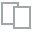
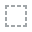
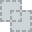
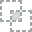
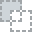
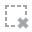
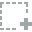
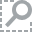
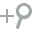
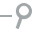
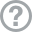
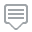
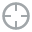
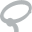
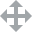
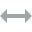
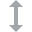
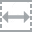
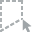
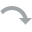
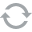
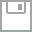
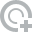
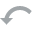
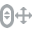
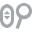
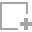
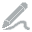
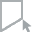
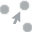
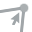
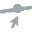

In [10]:
eda.plot_missing(df)

### Imputation

In [11]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include="number").columns
imp = SimpleImputer(strategy='mean')
df_imputed = imp.fit_transform(df[num_cols])

### Adding Indicator Columns

In [11]:
def add_indicator(col):
    def wrapper(df):
        return df[col].isna().astype(int)

    return wrapper

In [22]:
df1 = df.assign(Cabin_Missing=add_indicator("Cabin"))
df1.head()

In [14]:
df.add_column(column_name="Cabin_Missing", value=add_indicator("Cabin")).head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  \
0      0         A/5 21171   7.2500   NaN        S   
1      0          PC 17599  71.2833   C85        C   
2      0  STON/O2. 3101282   7.9250   NaN        S   
3      0            113803  53.1000  C123        S   
4      0            373450   8.0500   NaN        S   

                                       Cabin_Missing  
0  <function add_indicator.<locals>.wrapper at 0x...  
1  <function add_indicator.<locals>.wrapper at 0x...  
2  <function add_indicator.<locals>.wrapper at 0x...  
3  <function add_indicator.<locals>.wrapper at 0x...  
4  <function add_indicator.<locals>.wrapper at 0x...

## Cleaning Data

### Column Names

In [29]:
x_bad = pd.DataFrame(
    {
        "A": [1, None, 3],
        " sales numbers ": [20.0, 30.0, None],
    }
)

x_bad.clean_names()

a  _sales_numbers_
0  1.0             20.0
1  NaN             30.0
2  3.0              NaN

In [22]:
def clean_col(name):
    return (
        name.strip().lower().replace(" ", "_")
    )

x_bad.rename(columns=clean_col)

a  sales_numbers
0  1.0           20.0
1  NaN           30.0
2  3.0            NaN

### Replacing Missing Values

In [27]:
x_bad.fill_empty(columns=["A", " sales numbers "], value=10)

A   sales numbers 
0   1.0             20.0
1  10.0             30.0
2   3.0             10.0

In [28]:
 x_bad.coalesce(columns=["A", " sales numbers "], new_column_name="val")

val
0   1.0
1  30.0
2   3.0

## Exploring

In [4]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [8]:
def tweak_titanic(df):
    df = (
        df.drop(columns=["Name", "Ticket", "Cabin"])
            .pipe(pd.get_dummies, drop_first=True)
    )
    return df

def get_train_test_X_y(df, target, size=0.3, std_cols=None):
    X, y = df.get_features_targets(target_columns=target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    
    imp = IterativeImputer()
    fitted = imp.fit_transform(X_train[num_cols])
    
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = imp.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    
    if std_cols:
        std = StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "Pclass,Age,SibSp,Fare".split(",")

target = "Survived"

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, target, std_cols=std_cols)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [15]:
X.shape

(891, 9)

In [13]:
X.describe().iloc[:, [0, -1]]

pclass   embarked_S
count  1309.000000  1309.000000
mean     -0.012831     0.698243
std       0.995822     0.459196
min      -1.551881     0.000000
25%      -0.363317     0.000000
50%       0.825248     1.000000
75%       0.825248     1.000000
max       0.825248     1.000000

In [14]:
X.iloc[[1, 4], -3:]

sex_male  embarked_Q  embarked_S
677         1           0           1
864         0           0           1

In [15]:
X.loc[[677, 864], "sex_male":]

sex_male  embarked_Q  embarked_S
677         1           0           1
864         0           0           1

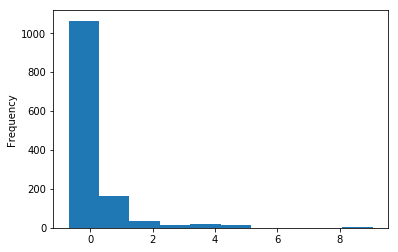

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind="hist", ax=ax)
#fig.savefig("images/mlpr_0601.png", dpi=300)

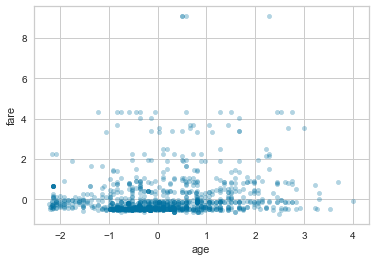

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))
X.plot.scatter(
    x="age", y="fare", ax=ax, alpha=0.3
)
#fig.savefig("images/mlpr_0603.png", dpi=300)

In [33]:
X.age.corr(X.fare)

0.17719980495717755

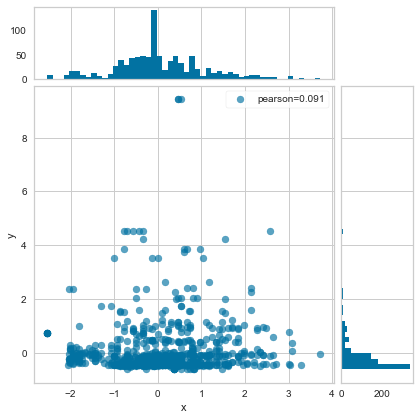

<AxesSubplot:xlabel='x', ylabel='y'>

In [17]:
from yellowbrick.features import JointPlotVisualizer

_, ax = plt.subplots(figsize=(6, 6))
jpv = JointPlotVisualizer(feature="Age", target="Fare")
jpv.fit(X["Age"], X["Fare"])
jpv.poof()

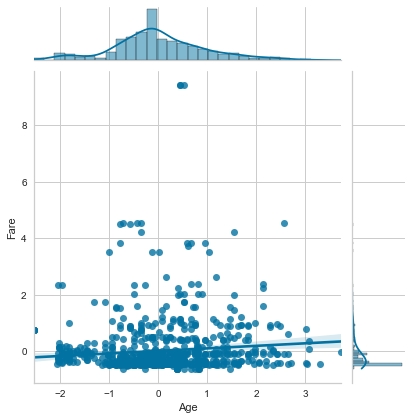

In [18]:
new_df = X.copy()
new_df["target"] = y
p = sns.jointplot(data=new_df, x="Age", y="Fare", kind="reg")

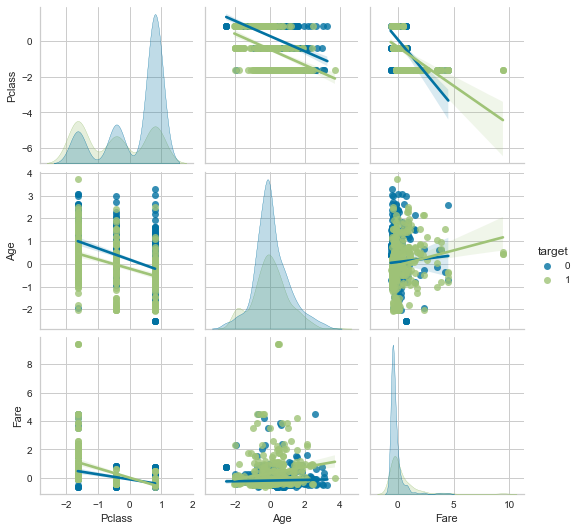

In [19]:
new_df = X.copy()
new_df["target"] = y
xs = ["Pclass", "Age", "Fare"]
p = sns.pairplot(data=new_df, vars=xs, hue="target", kind="reg")

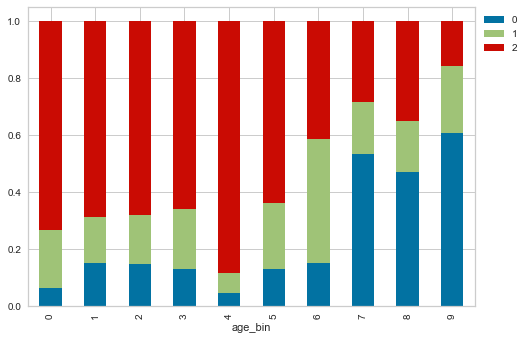

In [23]:
(
    X.assign(
        age_bin=pd.qcut(X['Age'], q=10, labels=False),
        class_bin=pd.cut(X['Pclass'], bins=3, labels=False),
    )
    .pipe(lambda df: pd.crosstab(df.age_bin, df.class_bin))
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(stacked=True)
    .legend(bbox_to_anchor=(1, 1))
)

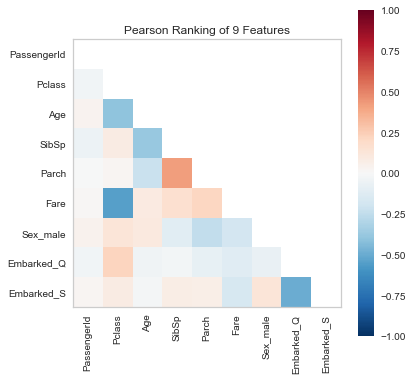

<AxesSubplot:title={'center':'Pearson Ranking of 9 Features'}>

In [24]:
import yellowbrick.features as ybf

_, ax = plt.subplots(figsize=(6, 6))

X1 = X.select_dtypes(include="number")

pcv = ybf.Rank2D(features=X1.columns, algorithm="pearson")
pcv.fit(X1, y)
pcv.transform(X1)
pcv.poof()

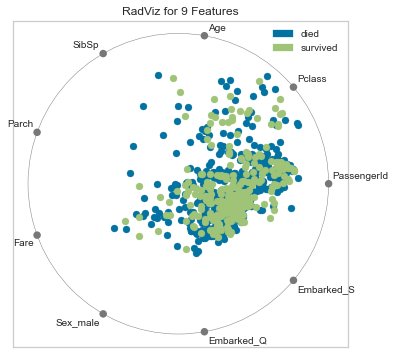

<AxesSubplot:title={'center':'RadViz for 9 Features'}>

In [25]:
_, ax = plt.subplots(figsize=(6, 6))
rv = ybf.RadViz(features=X.columns, classes=["Died", "Survived"])
rv.fit(X, y)
rv.transform(X)
rv.poof()

<ipython-input-29-e54fc904e973>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


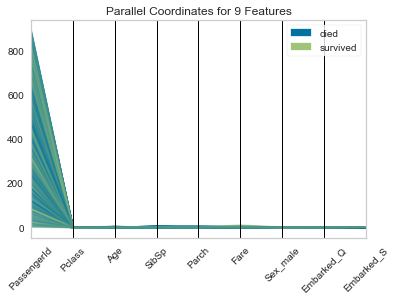

<AxesSubplot:title={'center':'Parallel Coordinates for 9 Features'}>

In [29]:
_, ax = plt.subplots(figsize=(6, 4))

pc = ybf.ParallelCoordinates(features=X.columns, classes=["died", "survived"])
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
pc.poof()

In [112]:
y_col = "Survived"
df1 = df.drop(columns = ['PassengerId', 'Parch'])
X, y = df1.drop(columns=y_col), df1[y_col]

size = 0.3

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=42
    )

def prep(X_train, X_test):

    num_cols = df1.select_dtypes(include="number").columns.to_list()
    num_cols.remove(y_col)

    imp = IterativeImputer()
    fitted = imp.fit_transform(X_train[num_cols])
    test_fit = imp.transform(X_test[num_cols])
    
    scale = StandardScaler()
    fitted = scale.fit_transform(fitted)
    test_fit = scale.transform(test_fit)
    
    return pd.DataFrame(fitted, columns=num_cols), pd.DataFrame(test_fit, columns=num_cols)
        
fitted, test_fit = prep(X_train, X_test)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [120]:
X.isnull().mean() * 100

Pclass       0.000000
Name         0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

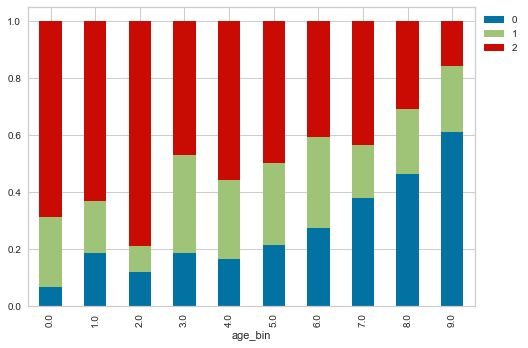

In [20]:
(
    X.assign(
        age_bin=pd.qcut(X['Age'], q=10, labels=False),
        class_bin=pd.cut(X['Pclass'], bins=3, labels=False),
    )
    .pipe(lambda df: pd.crosstab(df.age_bin, df.class_bin))
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(stacked=True)
    .legend(bbox_to_anchor=(1, 1))
)

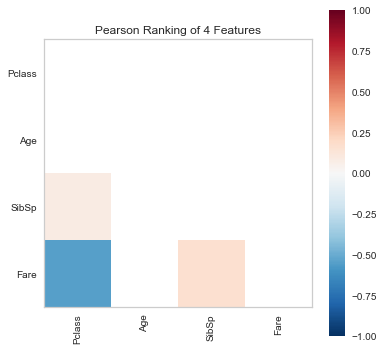

<AxesSubplot:title={'center':'Pearson Ranking of 4 Features'}>

In [117]:
import yellowbrick.features as ybf

_, ax = plt.subplots(figsize=(6, 6))

X1 = X.select_dtypes(include="number")

pcv = ybf.Rank2D(features=X1.columns, algorithm="pearson")
pcv.fit(X1, y)
pcv.transform(X1)
pcv.poof()

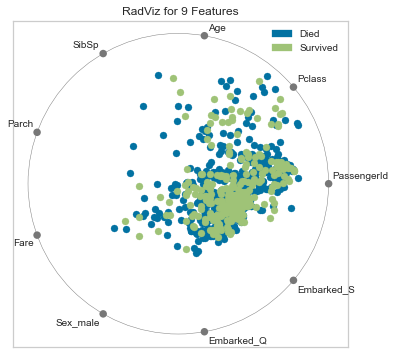

<AxesSubplot:title={'center':'RadViz for 9 Features'}>

In [30]:
_, ax = plt.subplots(figsize=(6, 6))

rv = ybf.RadViz(features=X.columns, classes=["Died", "Survived"])
rv.fit(X, y)
rv.transform(X)
rv.poof()

<ipython-input-31-d5e2b2b17c87>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


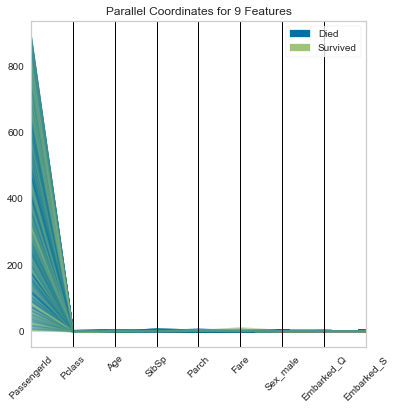

<AxesSubplot:title={'center':'Parallel Coordinates for 9 Features'}>

In [31]:
_, ax = plt.subplots(figsize=(6, 6))

pc = ybf.ParallelCoordinates(features=X.columns, classes=["Died", "Survived"])
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
pc.poof()

## Categorical Data

In [33]:
X_cat = pd.DataFrame(
   {
       "A": [1, None, 3],
       "names": [
           "Fred,George",
           "George",
           "John,Paul"
       ]
   }
)
X_cat

A        names
0  1.0  Fred,George
1  NaN       George
2  3.0    John,Paul

### Dummy Variables

In [45]:
pd.get_dummies(X_cat, prefix='', prefix_sep='', columns=['names'])

A  Fred,George  George  John,Paul
0  1.0            1       0          0
1  NaN            0       1          0
2  3.0            0       0          1

In [62]:
(
    X_cat['names']
    .str.split(',')
    .str.get_dummies()
)

['Fred', 'George']  ['George']  ['John', 'Paul']
0                   1           0                 0
1                   0           1                 0
2                   0           0                 1

In [51]:
X_cat.expand_column(column_name="names", sep=",")

A        names  Fred  George  John  Paul
0  1.0  Fred,George     1       1     0     0
1  NaN       George     0       1     0     0
2  3.0    John,Paul     0       0     1     1

### Label Encoder

In [53]:
lab = LabelEncoder()
lab.fit_transform(X_cat.names)

array([0, 1, 2])

In [56]:
lab.inverse_transform([0, 1, 2])

array(['Fred,George', 'George', 'John,Paul'], dtype=object)

In [68]:
(
    X_cat['names']
    .astype("category")
    .cat.as_ordered()
    .cat.codes + 1
)

0    1
1    2
2    3
dtype: int8

### Frequency Encoding

In [69]:
X_cat['names'].map(
    X_cat['names'].value_counts()
)

0    1
1    1
2    1
Name: names, dtype: int64

### Pulling Categories from Strings

In [4]:
df = pd.read_csv('../data/titanic_train.csv')
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [78]:
pattern_name = "([A-Za-z]+)\."
df['Name'].str.extract(pattern_name, expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Mme           1
Sir           1
Lady          1
Jonkheer      1
Don           1
Countess      1
Capt          1
Ms            1
Name: Name, dtype: int64

### Other Categorical Encoding

In [15]:
size_df = pd.DataFrame(
    {
        "name": ["Fred", "John", "Matt"],
        "size": ["small", "med", "xxl"],
    }
)

In [ ]:
# he = ce.HashingEncoder(verbose=0)
# he.fit_transform(size_df)

In [16]:
ore = ce.OrdinalEncoder(
    mapping=[
        {
            "col": "size",
            "mapping": {
                "small": 1,
                "med": 2,
                "lg": 3,
            },
        }
    ]
)

ore.fit_transform(size_df)

name  size
0  Fred   1.0
1  John   2.0
2  Matt  -1.0

In [21]:
titles = df['Name'].str.extract("([A-Za-z]+)\.", expand=False)
df1 = df.add_column(column_name='Title', value=titles)

te = ce.TargetEncoder(cols="Title") # 先验
te.fit_transform(df1, df['Survived'])["Title"].head()

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0    0.156673
1    0.792000
2    0.697802
3    0.792000
4    0.156673
Name: Title, dtype: float64

## Feature Selection

### Multicollinearity

In [26]:
agg = (
     df.groupby("Cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index()
)
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]
agg_df = df.merge(agg, on="Cabin")
agg_df.head()

PassengerId  Survived  Pclass  \
0            2         1       1   
1            4         1       1   
2          138         0       1   
3            7         0       1   
4           11         1       3   

                                                Name     Sex   Age  SibSp  \
0  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
2                        Futrelle, Mr. Jacques Heath    male  37.0      1   
3                            McCarthy, Mr. Timothy J    male  54.0      0   
4                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   

   Parch    Ticket     Fare  ... SibSp_mean SibSp_sum  Parch_min  Parch_max  \
0      0  PC 17599  71.2833  ...        1.0         1          0          0   
1      0    113803  53.1000  ...        1.0         2          0          0   
2      0    113803  53.1000  ...        1.0         2          0          0   
3      0     17463  51.8625  ...        0.0         0          0          0   
4      1   PP 9549  16.7000  ...        0.5         2          1          2   

   Parch_mean  Parch_sum  Fare_min  Fare_max  Fare_mean  Fare_sum  
0        0.00          0   71.2833   71.2833   71.28330   71.2833  
1        0.00          0   53.1000   53.1000   53.10000  106.2000  
2        0.00          0   53.1000   53.1000   53.10000  106.2000  
3        0.00          0   51.8625   51.8625   51.86250   51.8625  
4        1.25          5   10.4625   16.7000   13.58125   54.3250  

[5 rows x 40 columns]

In [27]:
limit = 0.95
corr = agg_df.corr()

mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

['Pclass_min',
 'Pclass_max',
 'Pclass_mean',
 'Age_mean',
 'SibSp_mean',
 'Parch_min',
 'Parch_mean',
 'Fare_mean']

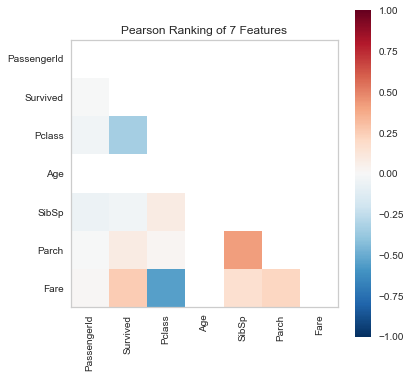

<AxesSubplot:title={'center':'Pearson Ranking of 7 Features'}>

In [31]:
X1 = df.select_dtypes(include="number")

pcv = ybf.Rank2D(features=X1.columns, algorithm="pearson")
pcv.fit(X1, y)
pcv.transform(X1)
pcv.poof()

### Recursive Feature Elimination

In [41]:
from sklearn.ensemble import *
import yellowbrick.model_selection as ybm

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


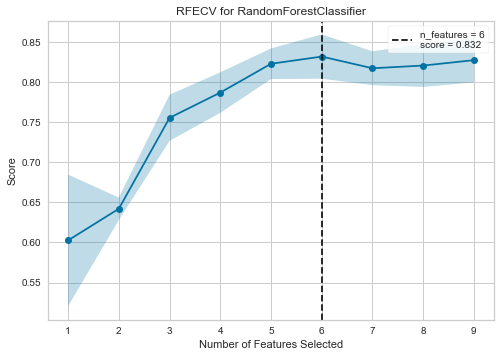

<AxesSubplot:title={'center':'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [47]:
rfc = RandomForestClassifier(n_estimators=100)

rfe = ybm.RFECV(model=rfc, cv=5)

rfe.fit(X, y)
rfe.poof()

In [35]:
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_

array([ True,  True,  True,  True, False,  True,  True, False, False])

In [37]:
from sklearn.feature_selection import *

In [39]:
model = RandomForestClassifier(n_estimators=100)
rfe = RFE(model, n_features_to_select=4)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['PassengerId', 'Age', 'Fare', 'Sex_male'], dtype='object')

### Mutual Information

<AxesSubplot:ylabel='feature'>

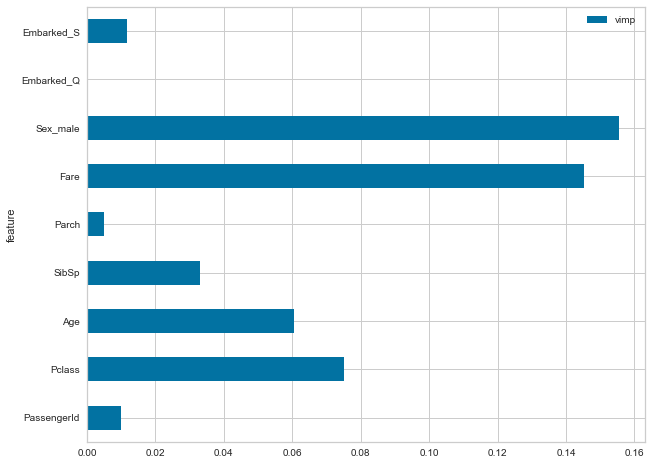

In [40]:
mic = mutual_info_classif(X, y)

fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {
            "feature": X.columns,
            "vimp": mic
        })
    .set_index("feature")
    .plot.barh(ax=ax)
)

## Imbalanced Classes

In [50]:
from sklearn.utils import resample

mask = df.Survived == 1
surv_df, death_df = df[mask], 
 = df[~mask]

df_upsample = resample(surv_df, replace=True, n_samples=len(death_df), random_state=42)
df2 = pd.concat([death_df, df_upsample])
df2.Survived.value_counts()

0    549
1    549
Name: Survived, dtype: int64

In [51]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_sample(X, y)
pd.Series(y_ros).value_counts()

0    549
1    549
Name: Survived, dtype: int64

In [56]:
from sklearn.utils import resample

mask = df.Survived == 1
surv_df, death_df = df[mask], df[~mask]

df_upsample = resample(death_df, replace=True, n_samples=len(surv_df), random_state=42)

df3 = pd.concat([surv_df, df_downsample])
df3.Survived.value_counts()

0    342
1    342
Name: Survived, dtype: int64